In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob

import tensorflow as tf
import pickle
import os
import glob
import random
import sys
import datetime
import wispy
import wispy.resnet
import wispy.logger
import wispy.utils
import wispy.callbacks
import wispy.model_utils
from tomlkit import parse
from tensorflow.keras.utils import get_custom_objects
import pugna.activations

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
import phenom

In [3]:
from wispy import lalutils, rotations 

In [4]:
sys.path.append("../")

In [5]:
import fit

In [6]:
import data_generation_coprec

In [7]:
get_custom_objects().update({'s2relu': pugna.activations.s2relu})
get_custom_objects().update({'ScaleLayer': wispy.mscalev3.ScaleLayer})

In [8]:
%matplotlib inline

In [9]:
def plot_modes(wr):
    plt.figure()
    plt.plot(wr.times, np.abs(wr.hlms[(2,2)]))
    plt.plot(wr.times, np.abs(wr.hlms[(2,1)]))
    plt.plot(wr.times, np.abs(wr.hlms[(2,0)]))
    plt.plot(wr.times, np.abs(wr.hlms[(2,-1)]))
    plt.plot(wr.times, np.abs(wr.hlms[(2,-2)]))
    plt.title(wr.frame)
    plt.show()
    plt.close()

# load data

In [10]:
filename = './training_data/times.npy'
times = np.load(filename)

pkl_filename = './pre_processing/times_scaler.pkl'
with open(pkl_filename, 'rb') as file:
    times_scaler = pickle.load(file)

times_scaled = times_scaler.transform(times[:, np.newaxis])

In [11]:
coords = np.load('./validation_data/coords.npy').T

In [12]:
data = {}
data['amp_22'] = np.load('./validation_data/amp_22.npy')
data['amp_21'] = np.load('./validation_data/amp_21.npy')
data['phi_22'] = np.load('./validation_data/phi_22.npy')
data['phi_21'] = np.load('./validation_data/phi_21.npy')
data['alpha'] = np.load('./validation_data/alpha.npy')
data['beta'] = np.load('./validation_data/beta.npy')
data['gamma'] = np.load('./validation_data/gamma.npy')

In [13]:
def wr_from_data(coords, i):
    y22_complex = data['amp_22'][i] * np.exp(1.j*data['phi_22'][i]) 
    y21_complex = data['amp_21'][i] * np.exp(1.j*data['phi_21'][i])
    
#     plt.figure()
#     plt.plot(times_scaled, np.real(y22_complex))
#     plt.plot(times_scaled, np.real(y21_complex))
    
    
    hlms = {}
    hlms[(2,2)] = y22_complex
    hlms[(2,1)] = y21_complex
    hlms[(2,0)] = np.zeros(len(y22_complex))*1.j
    hlms[(2,-1)] = y21_complex.conj().copy()
    hlms[(2,-2)] = y22_complex.conj().copy()
    
    wr = rotations.WaveformRotations(
        times=times,
        hlms=hlms,
        frame='coprec',
        alpha=data['alpha'][i],
        beta=data['beta'][i],
        gamma=data['gamma'][i]
    ) 
    
    m1, m2 = phenom.m1_m2_M_q(100, coords[0])
    f_ref = 10.
    phiRef = 0.
    s1x, s1y, s1z = data_generation_coprec.polar_to_cart(coords[1], coords[2], coords[3])
    s2x, s2y, s2z = data_generation_coprec.polar_to_cart(coords[4], coords[5], coords[6])
    
    thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
        mass1=m1, mass2=m2, f_ref=f_ref, inc=0, phiref=phiRef,
        spin1x=s1x, spin1y=s1y, spin1z=s1z,
        spin2x=s2x, spin2y=s2y, spin2z=s2z)
#     print(thetaJN, alpha0, phi_aligned)
    
    wr.set_alpha0_thetaJN_phi0(alpha0, thetaJN, phi_aligned)
    
    return wr

In [14]:
index = 2

In [15]:
coords[index]

array([3.48150402, 0.86186228, 2.13103554, 2.27371883, 0.        ,
       0.        , 0.        ])

In [16]:
wr_data = wr_from_data(coords[index], index)

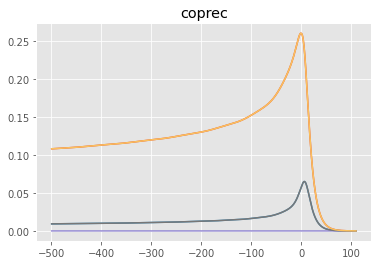

In [17]:
plot_modes(wr_data)

In [18]:
wr_data.from_coprecessing_frame_to_inertial_frame()

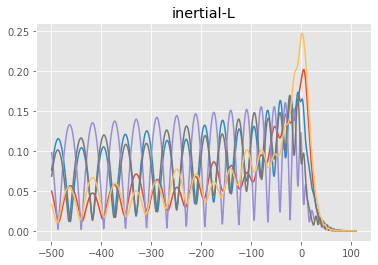

In [19]:
plot_modes(wr_data)

# load model

In [20]:
def get_input_for_ann(times, coords):
    return np.column_stack((times[:, 0], (coords*np.ones(times.shape))))

In [21]:
models = {}
models['amps'] = tf.keras.models.load_model('amps/009/checkpoint/cp-02080.ckpt')
models['alpha'] = tf.keras.models.load_model('alpha/009/checkpoint/cp-02870.ckpt')
models['beta'] = tf.keras.models.load_model('beta/009/checkpoint/cp-02810.ckpt')
models['gamma'] = tf.keras.models.load_model('gamma/009/checkpoint/cp-02850.ckpt')
models['phi_22'] = tf.keras.models.load_model('phi_22/009/checkpoint/cp-04850.ckpt')
models['phi_21'] = tf.keras.models.load_model('phi_21/009/checkpoint/cp-03800.ckpt')

In [22]:
preprocparams = dict(np.load('./pre_processing/preprocessing_params.npz'))

In [23]:
def predict_model(times_scaled, coords):
    
    X = get_input_for_ann(times_scaled, coords)
    
    amp22, amp21 = models['amps'].predict(X).T
    amp22 = amp22*preprocparams['amp_22']
    amp21 = amp21*preprocparams['amp_21']
    alpha = models['alpha'].predict(X)[:,0]*preprocparams['alpha']
    beta = models['beta'].predict(X)[:,0]*preprocparams['beta']
    gamma = models['gamma'].predict(X)[:,0]*preprocparams['gamma']
    
    phi_22 = models['phi_22'].predict(X)[:,0]*preprocparams['phi_22']
    phi_21 = models['phi_21'].predict(X)[:,0]*preprocparams['phi_21']
#     phi_22, phi_21 = models['phis'].predict(X).T
#     phi_22 = phi_22*preprocparams['phi_22']
#     phi_21 = phi_21*preprocparams['phi_21']
    
    y22_complex = amp22 * np.exp(1.j*phi_22) 
    y21_complex = amp21 * np.exp(1.j*phi_21)
    
#     plt.figure()
#     plt.plot(times_scaled, np.real(y22_complex))
#     plt.plot(times_scaled, np.real(y21_complex))
    
    
#     y22_complex = data['amp_22'][67] * np.exp(1.j*data['phi_22'][67]) 
#     y21_complex = data['amp_21'][67] * np.exp(1.j*data['phi_21'][67])
    
#     y22_complex = amp22 * np.exp(1.j*data['phi_22'][67]) 
#     y21_complex = data['amp_21'][67] * np.exp(1.j*data['phi_21'][67])

#     y22_complex = data['amp_22'][67] * np.exp(1.j*phi_22) 
#     y21_complex = data['amp_21'][67] * np.exp(1.j*data['phi_21'][67])

    
    
    hlms_ann = {}
    hlms_ann[(2,2)] = y22_complex
    hlms_ann[(2,1)] = y21_complex
    hlms_ann[(2,0)] = np.zeros(len(y22_complex))*1.j
    hlms_ann[(2,-1)] = y21_complex.conj().copy()
    hlms_ann[(2,-2)] = y22_complex.conj().copy()
    
    wr_ann = rotations.WaveformRotations(
        times=times,
        hlms=hlms_ann,
        frame='coprec',
        alpha=alpha,
        beta=beta,
        gamma=gamma
    ) 
    
    m1, m2 = phenom.m1_m2_M_q(100, coords[0])
    f_ref = 10.
    phiRef = 0.
    s1x, s1y, s1z = data_generation_coprec.polar_to_cart(coords[1], coords[2], coords[3])
    s2x, s2y, s2z = data_generation_coprec.polar_to_cart(coords[4], coords[5], coords[6])
    
    thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
        mass1=m1, mass2=m2, f_ref=f_ref, inc=0, phiref=phiRef,
        spin1x=s1x, spin1y=s1y, spin1z=s1z,
        spin2x=s2x, spin2y=s2y, spin2z=s2z)
#     print(thetaJN, alpha0, phi_aligned)
    
    wr_ann.set_alpha0_thetaJN_phi0(alpha0, thetaJN, phi_aligned)
    
    return wr_ann

In [24]:
wr_ann = predict_model(times_scaled, coords[index])

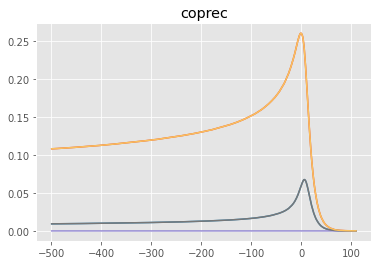

In [25]:
plot_modes(wr_ann)

In [26]:
wr_ann.from_coprecessing_frame_to_inertial_frame()

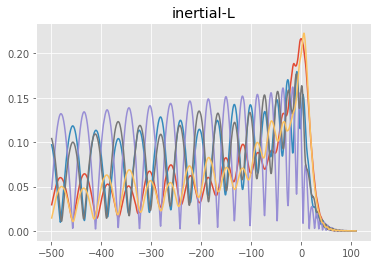

In [27]:
plot_modes(wr_ann)

# dev comparison

In [28]:
def match(h1, h2, times):

    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df

    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)

    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm

    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)


    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    res = ifft / h1h1 / h2h2 * 4 * dt

    return np.max(np.abs(res))

In [29]:
wr_ann.times

array([-499.50433261, -499.00433261, -498.50433261, ...,  108.49566739,
        108.99566739,  109.49566739])

In [30]:
wr_ann.hlms[(2,2)].real

array([-1.09822468e-02, -1.19801678e-02, -1.29769002e-02, ...,
        1.12068480e-05,  2.48118315e-05,  4.07810877e-05])

In [31]:
match(wr_ann.hlms[(2,2)].real, wr_data.hlms[(2,2)].real, wr_ann.times)

0.7739041284094087

In [32]:
match(wr_ann.hlms[(2,2)].imag, wr_data.hlms[(2,2)].imag, wr_ann.times)

0.821397847879697

In [33]:
match(wr_ann.hlms[(2,1)].real, wr_data.hlms[(2,1)].real, wr_ann.times)

0.8999837957545932

In [34]:
match(wr_ann.hlms[(2,1)].imag, wr_data.hlms[(2,1)].imag, wr_ann.times)

0.8403475315921823

In [35]:
phenom.MtoS(wr_ann.times, 100)

array([-0.24603041, -0.24578414, -0.24553786, ...,  0.05343944,
        0.05368572,  0.05393199])

In [36]:
match(wr_ann.hlms[(2,2)].real, wr_data.hlms[(2,2)].real, phenom.MtoS(wr_ann.times, 100))

0.7739041284094087

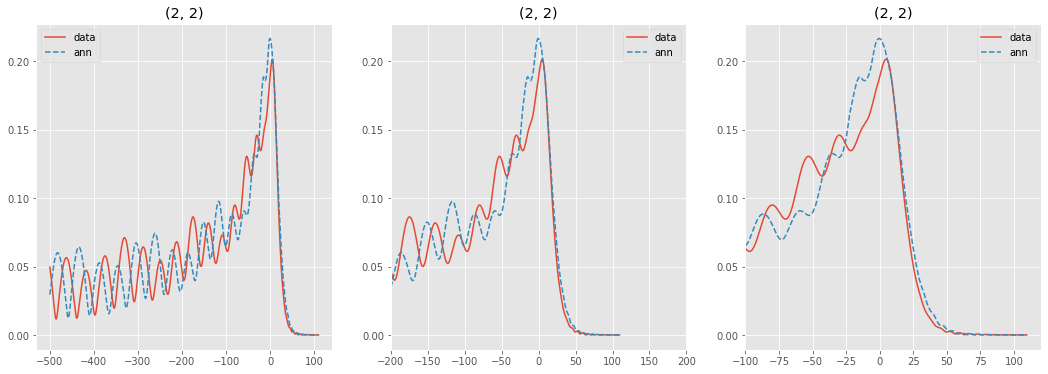

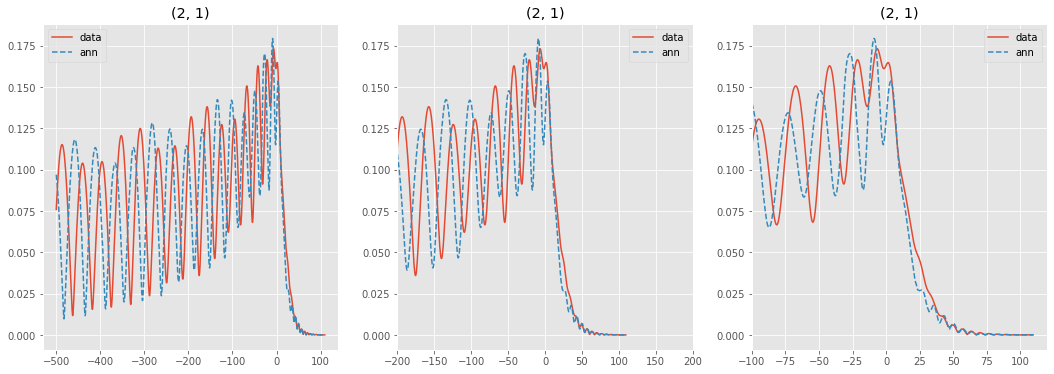

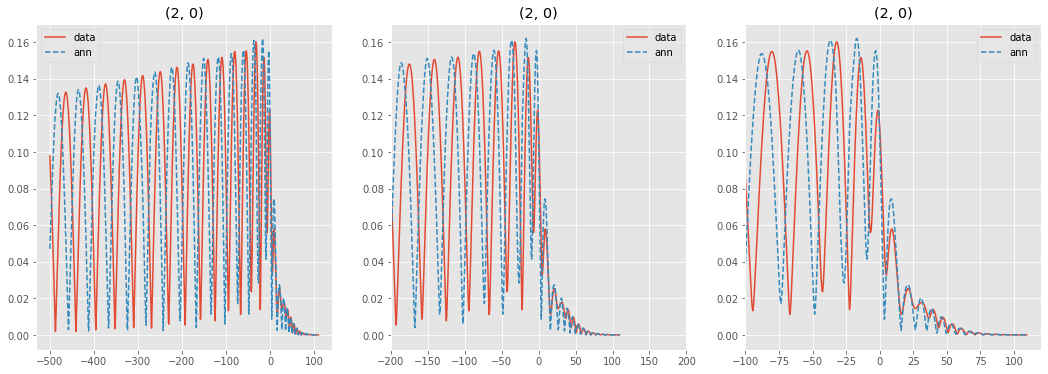

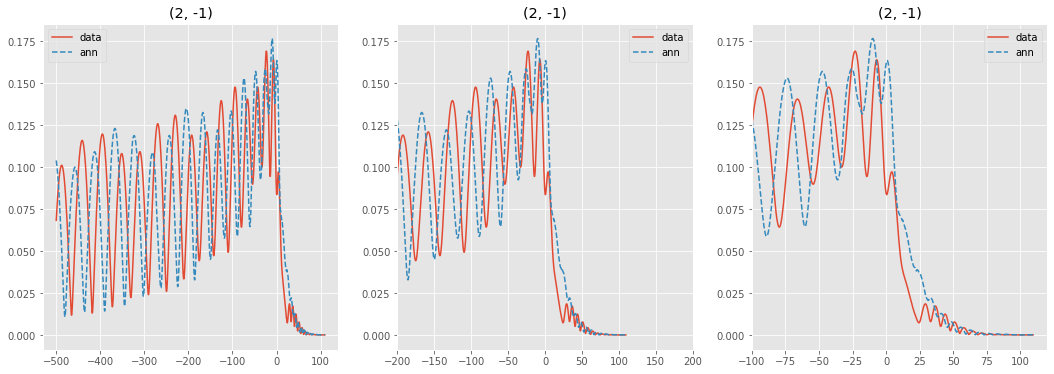

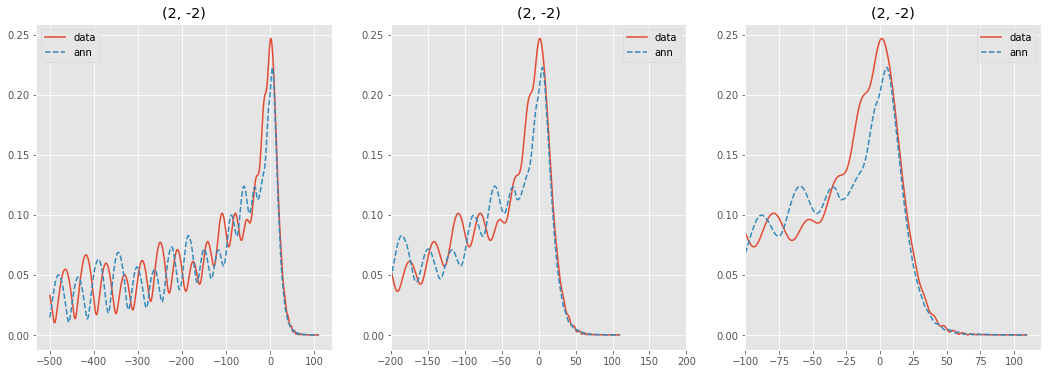

In [37]:
for key in wr_data.hlms.keys():
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(times, np.abs(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.abs(wr_ann.hlms[key]), label='ann', ls='--')
#     plt.xlim(-0.5,0.1)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(times, np.abs(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.abs(wr_ann.hlms[key]), label='ann',ls='--')
    plt.xlim(-200, 200)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(times, np.abs(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.abs(wr_ann.hlms[key]), label='ann',ls='--')
    plt.xlim(-100, 120)
    plt.title(key)
    plt.legend()

In [38]:
# loop over waveforms
# loop over modes
# compute match

In [39]:
# %%time
# matches = np.empty(shape=(len(coords), 5))
# # matches = np.empty(shape=(300, 5))

# # for i, coord in enumerate(coords[:300]):
# for i, coord in enumerate(coords):
#     wr_data = wr_from_data(coord, i)
#     wr_data.from_coprecessing_frame_to_inertial_frame()
#     wr_ann = predict_model(times_scaled, coord)
#     wr_ann.from_coprecessing_frame_to_inertial_frame()
#     keys = wr_data.hlms.keys()
#     for j, key in enumerate(keys):
#         matches[i, j] = match(wr_ann.hlms[key].real, wr_data.hlms[key].real, wr_ann.times)

CPU times: user 27min 32s, sys: 4min 4s, total: 31min 37s
Wall time: 12min 19s


In [91]:
# np.save("matches.npy", matches)

In [94]:
matches = np.load("matches.npy")

In [95]:
coords[2]

array([3.48150402, 0.86186228, 2.13103554, 2.27371883, 0.        ,
       0.        , 0.        ])

In [96]:
np.sum(matches[:,0] < 0.99)

89

In [97]:
f"{np.sum(matches[:,0] < 0.99)/len(matches)*100} % below match of 0.99" 

'8.9 % below match of 0.99'

Text(0.5, 0, 'q')

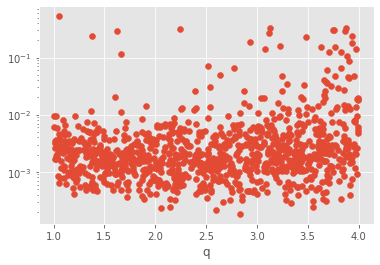

In [98]:
plt.figure()
plt.scatter(coords[:len(matches),0], 1-matches[:,0])
plt.yscale('log')
plt.xlabel('q')

Text(0.5, 0, 'chi1')

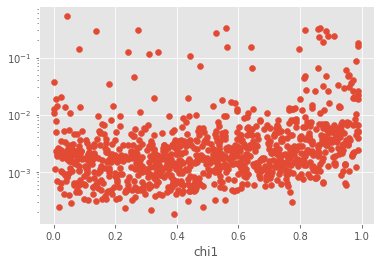

In [59]:
plt.figure()
plt.scatter(coords[:len(matches),1], 1-matches[:,0])
plt.yscale('log')
plt.xlabel('chi1')

Text(0.5, 0, 'theta1')

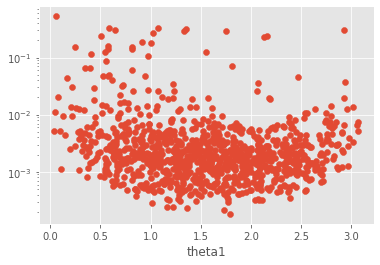

In [63]:
plt.figure()
plt.scatter(coords[:len(matches),2], 1-matches[:,0])
plt.yscale('log')
plt.xlabel('theta1')

Text(0.5, 0, 'phi1')

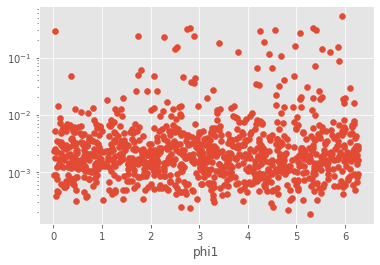

In [61]:
plt.figure()
plt.scatter(coords[:len(matches),3], 1-matches[:,0])
plt.yscale('log')
plt.xlabel('phi1')

Text(0, 0.5, 'theta1')

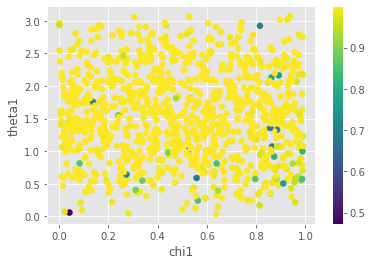

In [45]:
plt.figure()
plt.scatter(coords[:len(matches),1], coords[:len(matches),2], c=matches[:,0])
plt.colorbar()
plt.xlabel('chi1')
plt.ylabel('theta1')

Text(0, 0.5, 'theta1')

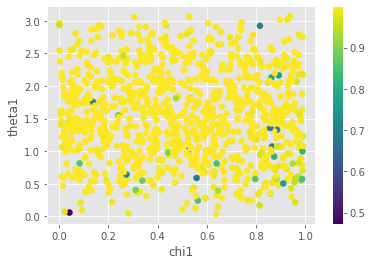

In [ ]:
plt.figure()
plt.scatter(coords[:len(matches),1], coords[:len(matches),2], c=matches[:,0])
plt.colorbar()
plt.xlabel('chi1')
plt.ylabel('phi1')

Text(0, 0.5, 'chi1')

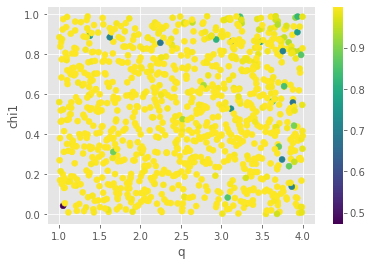

In [46]:
plt.figure()
plt.scatter(coords[:len(matches),0], coords[:len(matches),1], c=matches[:,0])
plt.colorbar()
plt.xlabel('q')
plt.ylabel('chi1')

Text(0, 0.5, 'theta1')

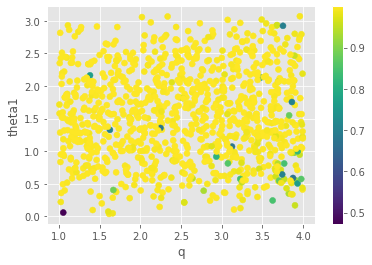

In [47]:
plt.figure()
plt.scatter(coords[:len(matches),0], coords[:len(matches),2], c=matches[:,0])
plt.colorbar()
plt.xlabel('q')
plt.ylabel('theta1')

Text(0, 0.5, 'phi1')

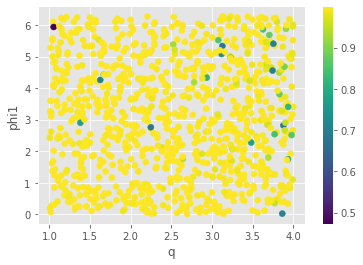

In [48]:
plt.figure()
plt.scatter(coords[:len(matches),0], coords[:len(matches),3], c=matches[:,0])
plt.colorbar()
plt.xlabel('q')
plt.ylabel('phi1')

In [49]:
from results import create_multidim_plot 

In [50]:
matches.shape

(1000, 5)

In [51]:
coords.shape

(1000, 7)

Text(0.5, 0.98, 'matches')

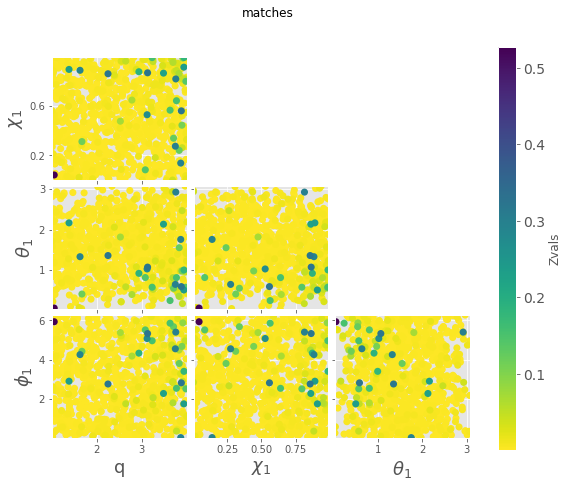

In [52]:

# mean = (1, 2)
# cov = [[1, 0], [0, 100]]
# x, y = np.random.multivariate_normal(mean, cov, (7, len(matches))).T

parameters = ['q', 'chi1', 'theta1', 'phi1']

samples = np.recarray(len(matches), dtype=[(p, float) for p in parameters])
for i in range(len(parameters)):
    samples[parameters[i]] = coords[:len(matches)].T[i]

zvals = 1-matches[:,0]
# zvals = 1-matches[:,1]
# zvals = 1-matches[:,2]

pars_to_show = ['q', 'chi1', 'theta1', 'phi1']
labels = {
    'q':'q',
    'chi1':r'$\chi_1$',
    'theta1':r'$\theta_1$',
    'phi1':r'$\phi_1$',
}

# mins = {'x0':-4, 'x1':-4, 'y0':-4}
# maxs = {'x0':4, 'x1':4, 'y0':4}

fig, axes_dict = create_multidim_plot(
    pars_to_show,
    samples,
    zvals=zvals,
    show_colorbar=True,
    labels=labels,
    cbar_label='Zvals',
    cb_scale=14,
    scatter_cmap='viridis_r',
    scatter_size=50
)
fig.suptitle('matches')

In [105]:
np.random.randint(100)

67

In [106]:
worst_idx = np.where(matches[:,0] < 0.99)[0]
print(worst_idx)

[  2  11  34  37  40  49  77  86 106 109 116 122 125 128 167 173 197 204
 223 225 253 254 258 276 278 281 292 313 316 321 364 370 375 387 413 419
 434 449 464 466 478 516 525 546 559 561 565 571 574 581 598 625 647 663
 665 670 682 687 693 695 702 707 730 733 746 750 770 779 781 786 788 818
 823 827 834 839 864 869 875 885 888 907 916 918 948 960 988 991 996]


In [107]:
best_idx = np.where(matches[:,0] > 0.99)[0]
print(best_idx)

[  0   1   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  38  39
  41  42  43  44  45  46  47  48  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  78
  79  80  81  82  83  84  85  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 107 108 110 111 112 113 114 115 117 118
 119 120 121 123 124 126 127 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 168 169 170 171 172 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 198 199 200 201 202 203 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 224 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 255
 256 257 259 260 261 262 263 264 265 266 267 268 26

In [173]:
def plot_compare_by_index(coords, index, fn=np.abs):
    
    print(index)
    print(matches[index])
    print(coords[index])
    
    wr_data = wr_from_data(coords[index], index)
    wr_data.from_coprecessing_frame_to_inertial_frame()
    wr_ann = predict_model(times_scaled, coords[index])
    wr_ann.from_coprecessing_frame_to_inertial_frame()
    
    for key in wr_data.hlms.keys():
        plt.figure(figsize=(18,6))
        plt.subplot(1,3,1)
        plt.plot(times, fn(wr_data.hlms[key]), label='data' )
        plt.plot(times, fn(wr_ann.hlms[key]), label='ann', ls='--')
    #     plt.xlim(-0.5,0.1)
        plt.title(key)
        plt.legend()

        plt.subplot(1,3,2)
        plt.plot(times, fn(wr_data.hlms[key]), label='data' )
        plt.plot(times, fn(wr_ann.hlms[key]), label='ann',ls='--')
        plt.xlim(-200, 200)
        plt.title(key)
        plt.legend()

        plt.subplot(1,3,3)
        plt.plot(times, fn(wr_data.hlms[key]), label='data' )
        plt.plot(times, fn(wr_ann.hlms[key]), label='ann',ls='--')
        plt.xlim(-100, 120)
        plt.title(key)
        plt.legend()

779
[0.95656664 0.80377302 0.95545198 0.84391105 0.95607942]
[3.90219274 0.81384464 0.16999951 2.90327767 0.         0.
 0.        ]


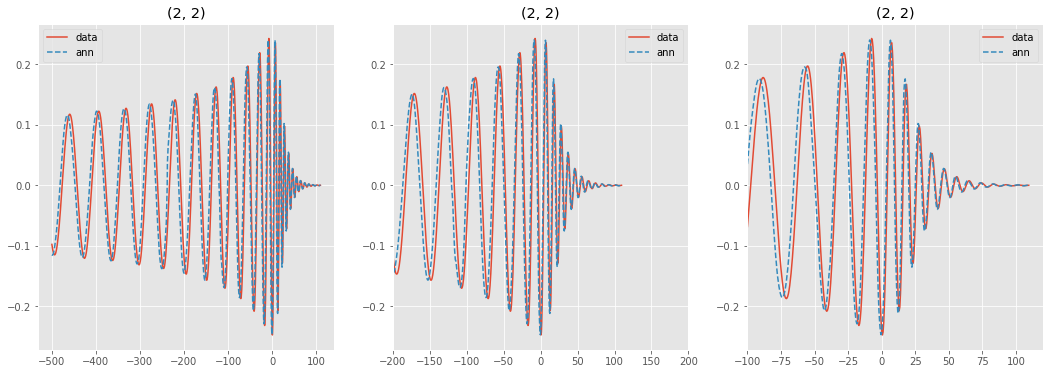

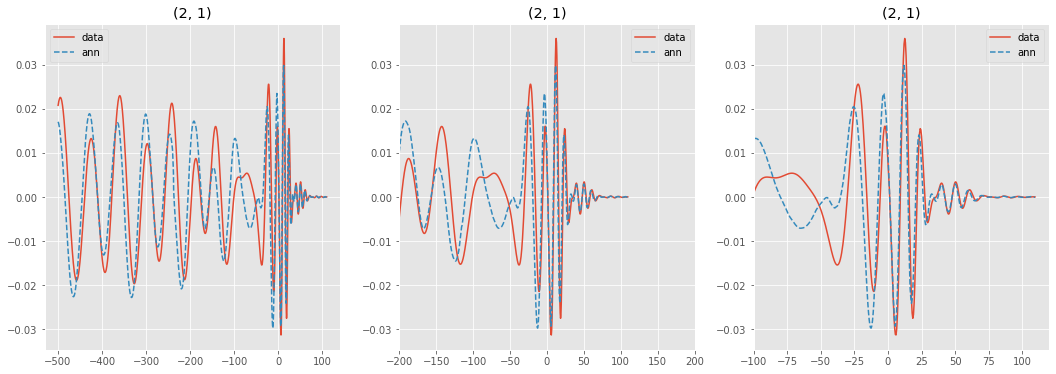

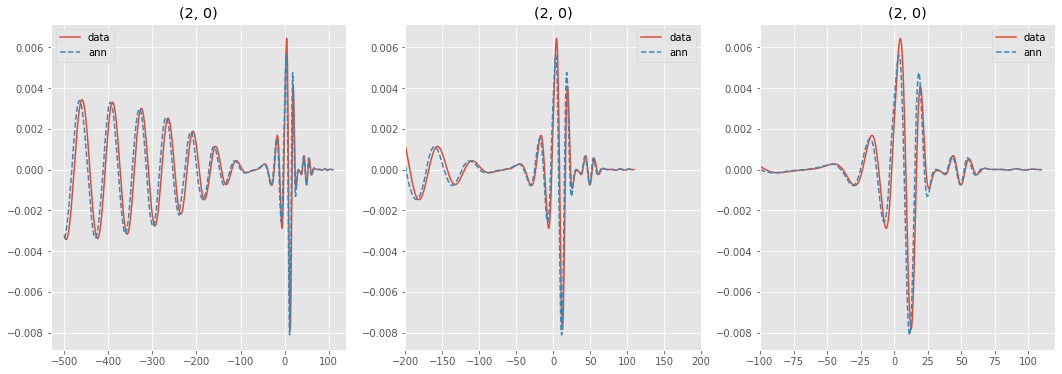

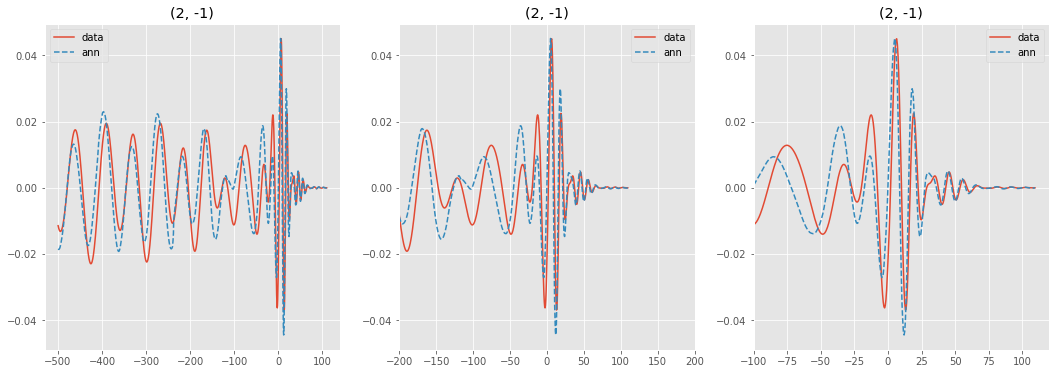

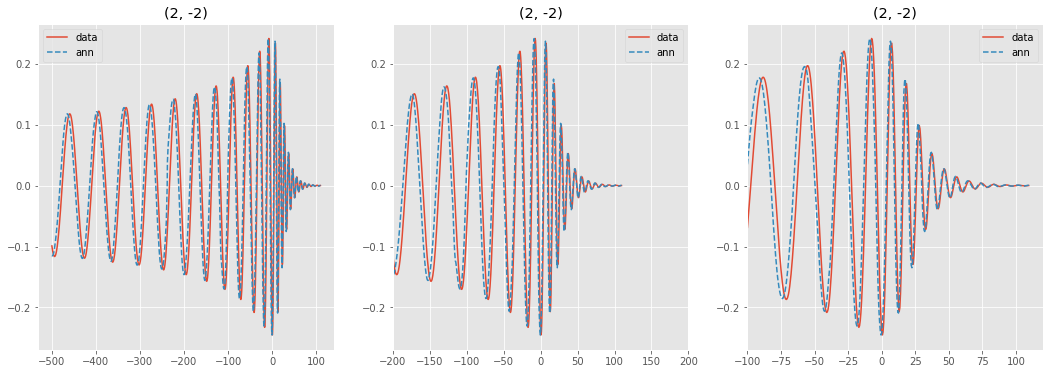

In [186]:
plot_compare_by_index(coords, worst_idx[np.random.randint(len(worst_idx))], fn=np.real)

168
[0.99877442 0.9984335  0.99763327 0.99907113 0.99876961]
[1.27210388 0.73617922 2.90413148 5.45199393 0.         0.
 0.        ]


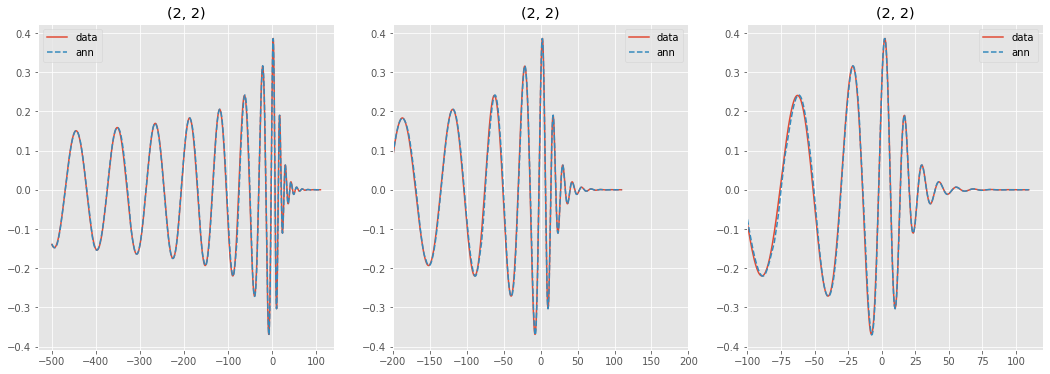

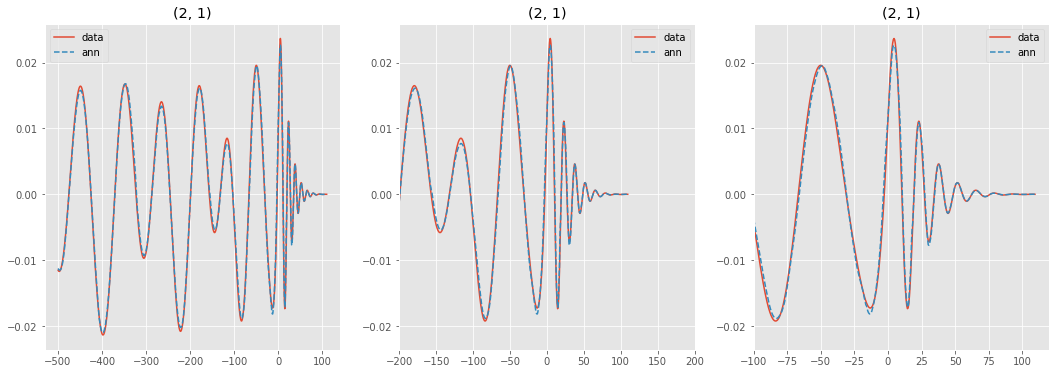

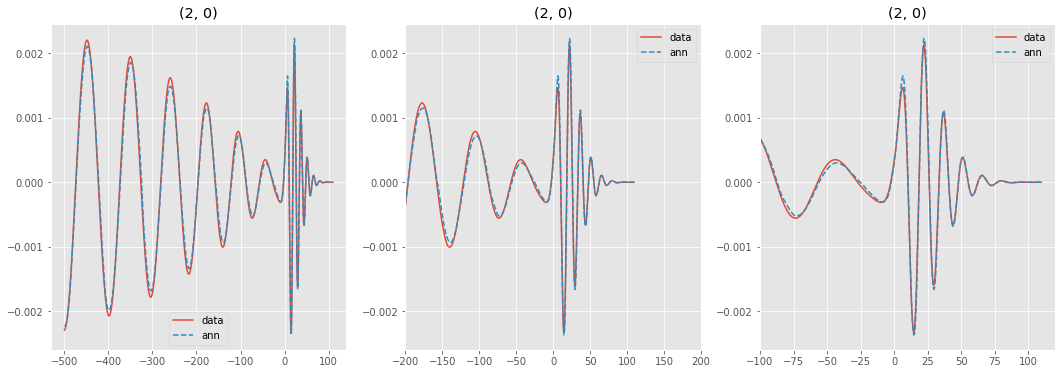

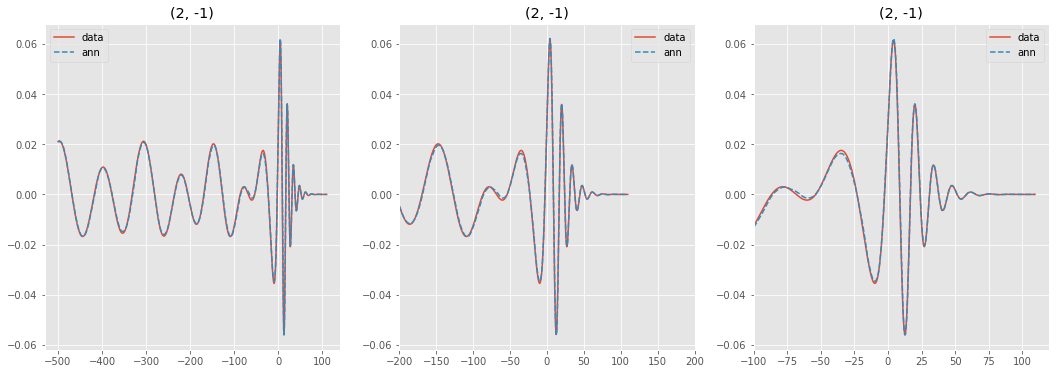

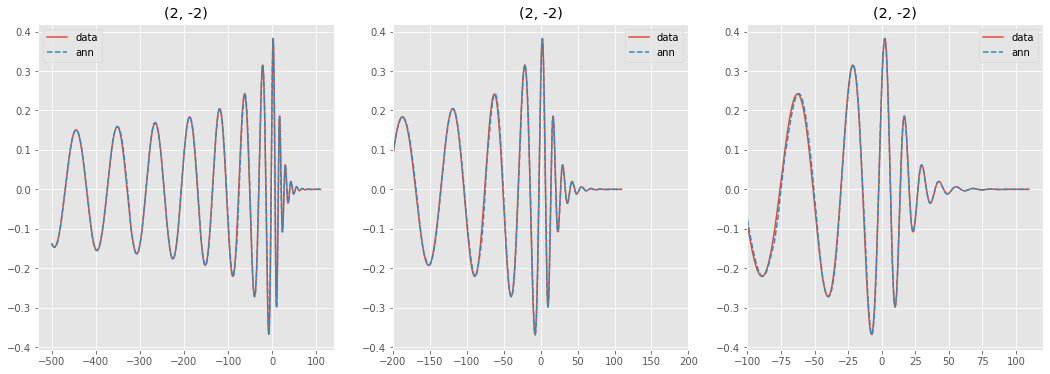

In [184]:
plot_compare_by_index(coords, best_idx[np.random.randint(len(best_idx))], fn=np.real)

In [180]:
np.where((matches[:,0] > 0.99) & (coords[:,0] > 3.) & (coords[:,1] > 0.98) & (coords[:,2] > 1.) & (coords[:,2] < 2.))[0]

array([644, 920])

644
[0.99760148 0.99895803 0.99886511 0.99869634 0.9975645 ]
[3.60713413 0.98709964 1.641243   1.66886338 0.         0.
 0.        ]


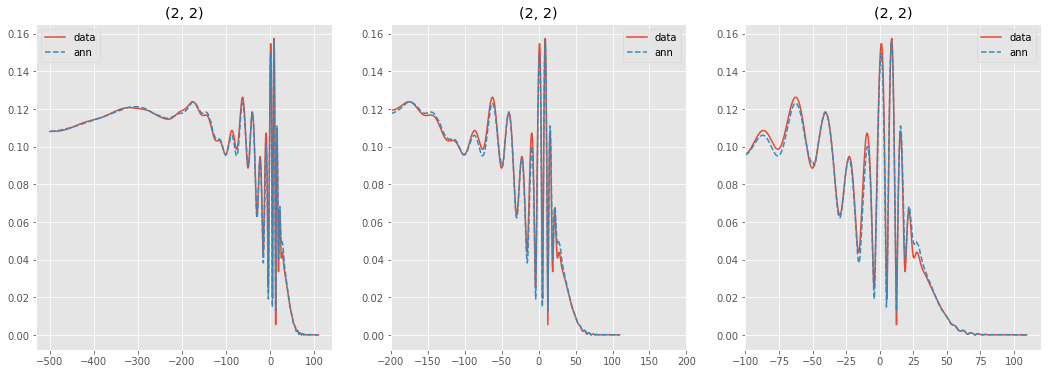

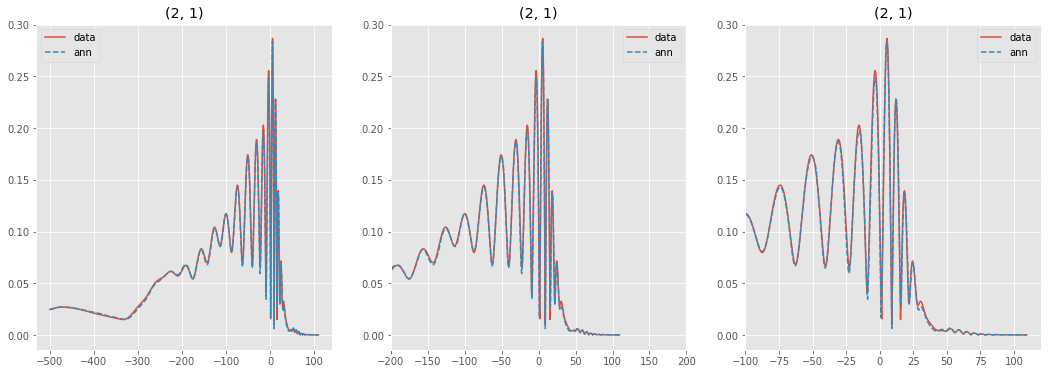

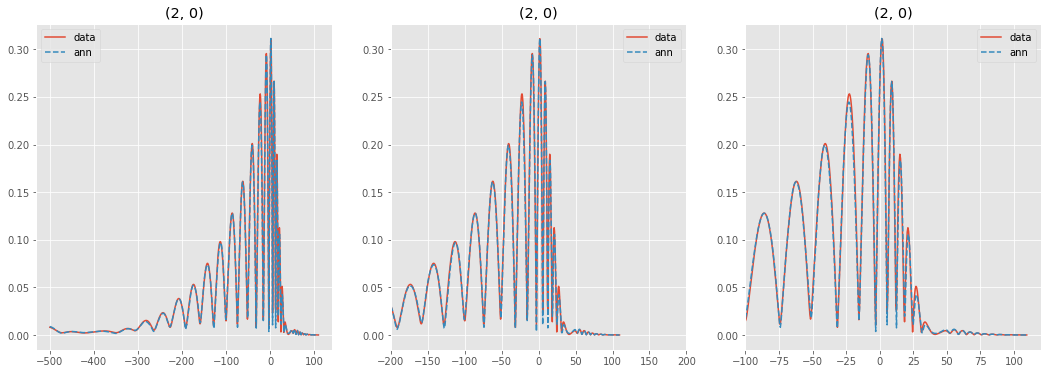

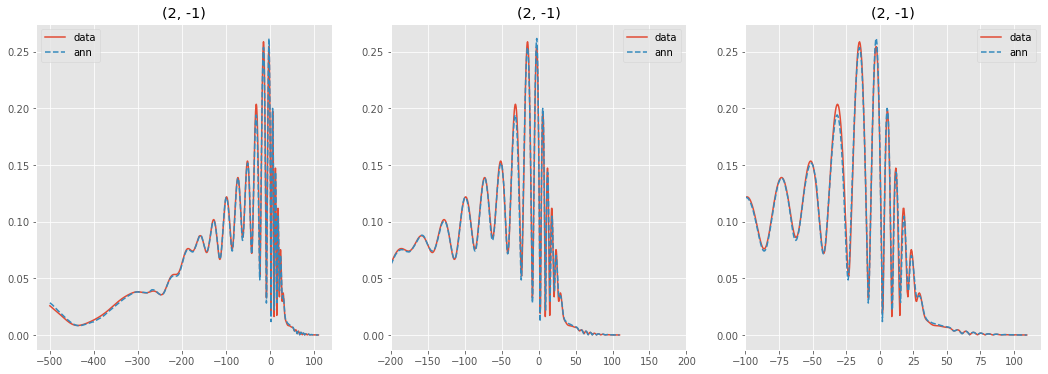

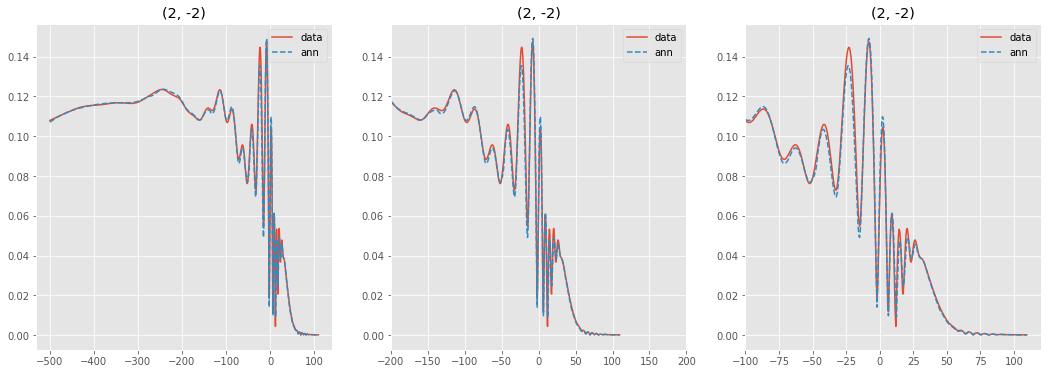

In [181]:
plot_compare_by_index(coords, 644, fn=np.abs)